# LDA Vs BERTopic

The goal of this projct is to compare **LDA** and **BERTopic** topic modelings in discovering what topics in **NLP** have been increasing or decreasing in use between the years of **2013** and **2020**. 

---

The dataset used for this project is a tsv file of 7,188 papers published at major **NLP** venues (**ACL**, **EMNLP**, **NAACL**, **TACL**, etc.) between **2013** and **2020**. Here is a sample of the data we'll use:

|id|year of publication|title|abstract|
|---|---|---|---|
|pimentel-etal-2020-phonotactic|2020|Phonotactic Complexity and Its Trade-offs|We present methods for calculating a measure of phonotactic complexity---bits per phoneme--- that permits a straightforward cross-linguistic comparison. When given a word, represented as a sequence of phonemic segments such as symbols in the international phonetic alphabet, and a statistical model trained on a sample of word types from the language, we can approximately measure bits per phoneme using the negative log-probability of that word under the model. This simple measure allows us to compare the entropy across languages, giving insight into how complex a language's phonotactics is. Using a collection of 1016 basic concept words across 106 languages, we demonstrate a very strong negative correlation of − 0.74 between bits per phoneme and the average length of words.|
|wang-etal-2020-amr|2020|AMR-To-Text Generation with Graph Transformer|Abstract meaning representation (AMR)-to-text generation is the challenging task of generating natural language texts from AMR graphs, where nodes represent concepts and edges denote relations. The current state-of-the-art methods use graph-to-sequence models; however, they still cannot significantly outperform the previous sequence-to-sequence models or statistical approaches. In this paper, we propose a novel graph-to-sequence model (Graph Transformer) to address this task. The model directly encodes the AMR graphs and learns the node representations. A pairwise interaction function is used for computing the semantic relations between the concepts. Moreover, attention mechanisms are used for aggregating the information from the incoming and outgoing neighbors, which help the model to capture the semantic information effectively. Our model outperforms the state-of-the-art neural approach by 1.5 BLEU points on LDC2015E86 and 4.8 BLEU points on LDC2017T10 and achieves new state-of-the-art performances.|


In [24]:
import nltk
import re
import gensim
from gensim import corpora
import operator

nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tinsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stop_words = stopwords.words('english')

In [4]:
def filter(word, stopwords):
    
    """ Function to exclude words from a text """
    
    # no stopwords
    if word in stopwords:
        return False
    
    # has to contain at least one letter
    if re.search("[A-Za-z]", word) is not None:
        return True
    
    return False

In [5]:
def read_docs(dataFile, stopwords):
    
    names=[]    
    docs=[]
   
    with open(dataFile, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            idd=cols[0]
            name=cols[2]
            year=int(cols[1])
        
            text=cols[3]
            
            tokens=nltk.word_tokenize(text.lower())
            tokens=[x for x in tokens if filter(x, stopwords)]
            docs.append(tokens)
            names.append((name, year))
    return docs, names

In [6]:
dataFile="data/acl.all.tsv"
data, doc_names=read_docs(dataFile, stop_words)

We will convert the data into a bag-of-words representation using gensim's [corpora.dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) methods.

In [8]:
# Create vocab from data; restrict vocab to only the top 10K terms that show up in at least 5 documents 
# and no more than 50% of all documents

dictionary = corpora.Dictionary(data)
dictionary.filter_extremes(no_below=5, no_above=.5, keep_n=10000)

In [13]:
# Replace dataset with numeric ids words in vocab (and exclude all other words)
corpus = [dictionary.doc2bow(text) for text in data]

In [17]:
K=50 #number of topics for LDA

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=K, 
                                           passes=100,
                                           alpha='auto')

We can get a sense of what the topics are by printing the top 10 words with highest $P(word \mid topic)$ for each topic

In [21]:
for i in range(K):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in lda_model.show_topic(i, topn=10)])))

topic 0:	question questions answer answering qa reading comprehension answers dataset reasoning
topic 1:	sentiment analysis classification classifier aspect aspects opinion words polarity classifiers
topic 2:	neural networks recurrent memory network lstm sequence models rnn word
topic 3:	generation text generate generating generated input models sequence-to-sequence human language
topic 4:	event corpus text texts events present temporal extraction information articles
topic 5:	morphological retrieval query queries surface change values search open-domain forms
topic 6:	adversarial models robustness tokens examples training inputs attacks input segmentation
topic 7:	phrases phrase expressions paraphrase paraphrases compositional identification metaphor expression referring
topic 8:	latent distribution generative variational variables models distributions modeling posterior probabilistic
topic 9:	evaluation human models dataset metrics quality automatic systems datasets performance
topic

Now let's print out the documents that have the highest topic representation -- i.e., for a given topic $k$, the documents with highest $P(topic=k | document)$ -- in order to ground these topic summaries with actual documents that contain those topics.

In [22]:
topic_model=lda_model 

topic_docs=[]
for i in range(K):
    topic_docs.append({})
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][doc_id]=topic_prob

for i in range(K):
    print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10)]))
    sorted_x = sorted(topic_docs[i].items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x[:5]:
        print("%s\t%.3f\t%s" % (i,v,doc_names[k]))
    print()

question questions answer answering qa reading comprehension answers dataset reasoning

0	0.708	('Bridging Information-Seeking Human Gaze and Machine Reading Comprehension', 2020)
0	0.572	('IIRC: A Dataset of Incomplete Information Reading Comprehension Questions', 2020)
0	0.489	('The Web as a Knowledge-Base for Answering Complex Questions', 2018)
0	0.432	('A dataset and baselines for sequential open-domain question answering', 2018)
0	0.424	("Know What You Don't Know: Unanswerable Questions for SQuAD", 2018)

sentiment analysis classification classifier aspect aspects opinion words polarity classifiers

1	0.392	('Modelling Context and Syntactical Features for Aspect-based Sentiment Analysis', 2020)
1	0.368	('Lingmotif: Sentiment Analysis for the Digital Humanities', 2017)
1	0.318	('Target-oriented Opinion Words Extraction with Target-fused Neural Sequence Labeling', 2019)
1	0.312	('Utilizing BERT for Aspect-Based Sentiment Analysis via Constructing Auxiliary Sentence', 2019)
1	0.293	(

ranking documents interpretable web clustering explanations predictions tool document explanation

28	0.430	('Towards Transparent and Explainable Attention Models', 2020)
28	0.352	('Hierarchical Modeling for User Personality Prediction: The Role of Message-Level Attention', 2020)
28	0.342	('Latent Geographical Factors for Analyzing the Evolution of Dialects in Contact', 2020)
28	0.309	('Learning to Deceive with Attention-Based Explanations', 2020)
28	0.306	('Tired of Topic Models? Clusters of Pretrained Word Embeddings Make for Fast and Good Topics too!', 2020)

dialogue dialog responses response conversation conversational systems utterances conversations system

29	0.477	('Towards Persona-Based Empathetic Conversational Models', 2020)
29	0.437	('Improving Open-Domain Dialogue Systems via Multi-Turn Incomplete Utterance Restoration', 2019)
29	0.428	('UniConv: A Unified Conversational Neural Architecture for Multi-domain Task-oriented Dialogues', 2020)
29	0.409	('A Practical Dialogue-A

In [26]:
def plot_category(a,b):
    plt.plot(a,b)
    plt.show()

question questions answer answering qa reading comprehension answers dataset reasoning



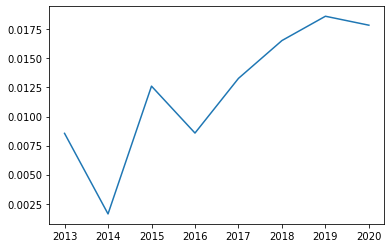

sentiment analysis classification classifier aspect aspects opinion words polarity classifiers



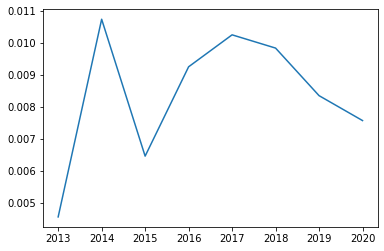

neural networks recurrent memory network lstm sequence models rnn word



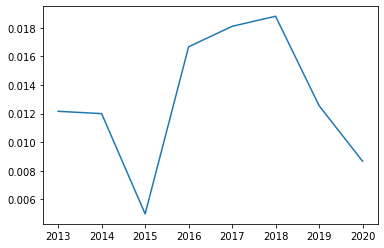

generation text generate generating generated input models sequence-to-sequence human language



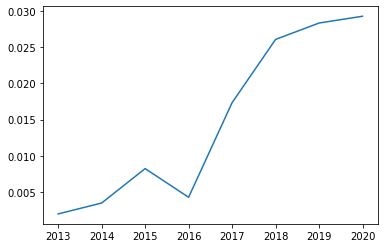

event corpus text texts events present temporal extraction information articles



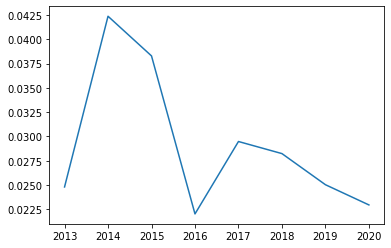

In [27]:
topic_model=lda_model 

start=2013
end=2021

window=end-start

topic_docs=[]
total_mass=np.zeros(window)

for i in range(K):
    topic_docs.append(np.zeros(window))
    
for doc_id in range(len(corpus)):
    doc_topics=topic_model.get_document_topics(corpus[doc_id])
    title, year=doc_names[doc_id]
    total_mass[year-start]+=1
    for topic_num, topic_prob in doc_topics:
        topic_docs[topic_num][year-start]+=topic_prob

for i in range(5):
    print("%s\n" % ' '.join([term for term, freq in topic_model.show_topic(i, topn=10)]))
    plot_category(range(2013,2021), topic_docs[i]/total_mass)
    
    
    